In [1]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560) 
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 

# merge X and y into one df
bikes_df = pd.concat([X, y], axis = 1)
print(bikes_df.isnull().sum())
bikes_df.head()
bikes_df.info()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew point temperature  8760 n

In [3]:
bikes_df['Date'] = pd.to_datetime(bikes_df['Date'], format="%d/%m/%Y")
bikes_df['Day'] = bikes_df['Date'].dt.day
bikes_df['Month'] = bikes_df['Date'].dt.month
bikes_df['Weekday'] = bikes_df['Date'].dt.weekday
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Date                   8760 non-null   datetime64[ns]
 1   Rented Bike Count      8760 non-null   int64         
 2   Hour                   8760 non-null   int64         
 3   Temperature            8760 non-null   float64       
 4   Humidity               8760 non-null   int64         
 5   Wind speed             8760 non-null   float64       
 6   Visibility             8760 non-null   int64         
 7   Dew point temperature  8760 non-null   float64       
 8   Solar Radiation        8760 non-null   float64       
 9   Rainfall               8760 non-null   float64       
 10  Snowfall               8760 non-null   float64       
 11  Seasons                8760 non-null   object        
 12  Holiday                8760 non-null   object        
 13  Fun

In [4]:
bikes_df = bikes_df.select_dtypes(include = ['float64', 'int64','int32'])
# Split into X (features) and y (target)
X = bikes_df.drop(columns=["Rented Bike Count"])
y = bikes_df["Rented Bike Count"]
bikes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Rented Bike Count      8760 non-null   int64  
 1   Hour                   8760 non-null   int64  
 2   Temperature            8760 non-null   float64
 3   Humidity               8760 non-null   int64  
 4   Wind speed             8760 non-null   float64
 5   Visibility             8760 non-null   int64  
 6   Dew point temperature  8760 non-null   float64
 7   Solar Radiation        8760 non-null   float64
 8   Rainfall               8760 non-null   float64
 9   Snowfall               8760 non-null   float64
 10  Day                    8760 non-null   int32  
 11  Month                  8760 non-null   int32  
 12  Weekday                8760 non-null   int32  
dtypes: float64(6), int32(3), int64(4)
memory usage: 787.2 KB


#### Analyzing distributions

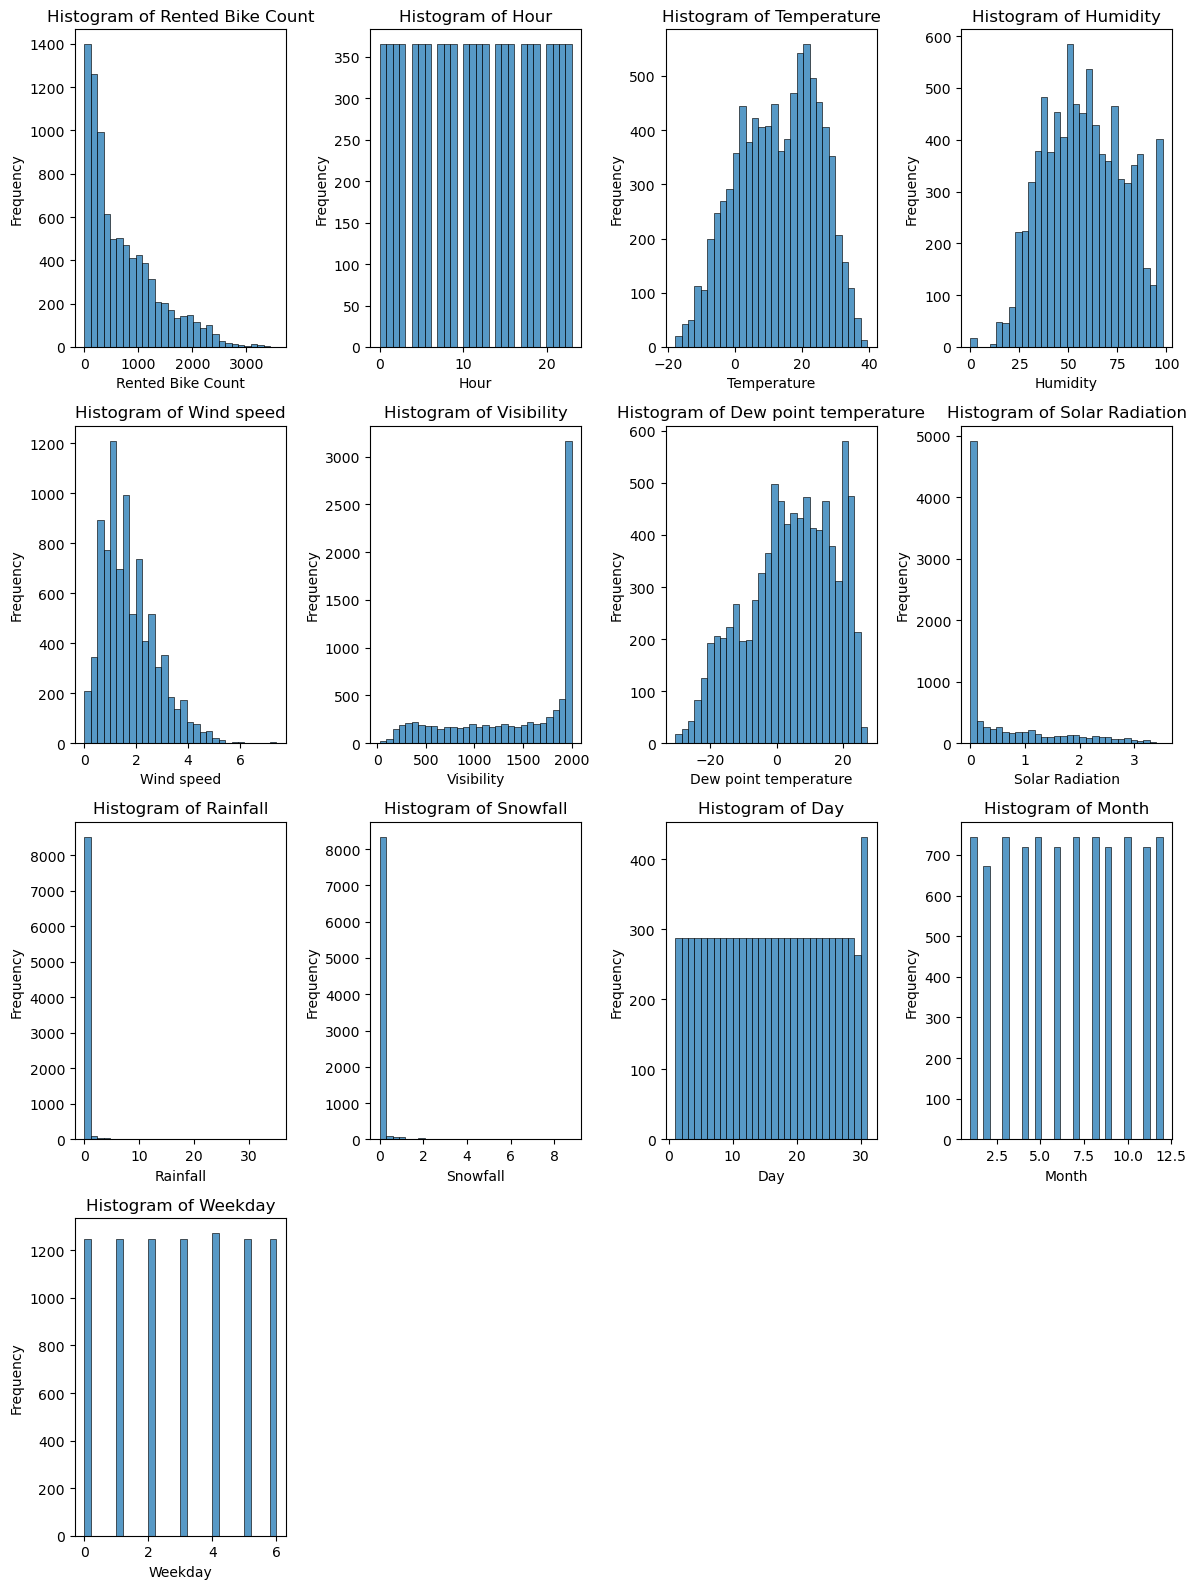

In [6]:
num_cols = len(bikes_df.columns)
fig, axes = plt.subplots(num_cols // 4 + 1, 4, figsize=(12, 4 * (num_cols // 4 + 1)))

axes = axes.flatten()

for idx, col in enumerate(bikes_df.columns):
    sns.histplot(data=bikes_df, x=col, kde=False, bins=30, ax=axes[idx])  # Histogram without KDE
    axes[idx].set_title(f"Histogram of {col}")
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel("Frequency")

for unused_ax in axes[len(bikes_df.columns):]:
    unused_ax.set_visible(False)

plt.tight_layout()

# Display the plots
plt.show()

* Correlation Matrix: A heatmap that shows the correlation values between features. Used to identify strong positive or negative correlations between the variables.
* VIF: A table showing the variance inflation factor for each feature.

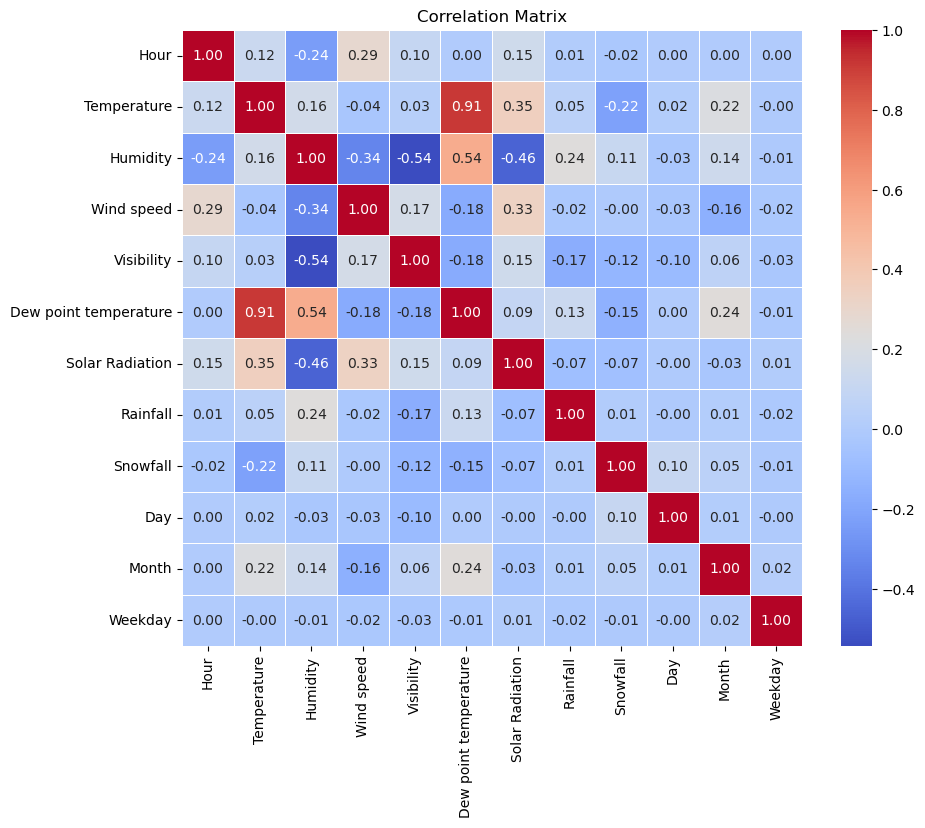

In [8]:
plt.figure(figsize=(10, 8))
corr_matrix = X.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Step 3**: Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]

# Show VIF
print("Variance Inflation Factor (VIF):")
print(vif_data)

Variance Inflation Factor (VIF):
                  feature        VIF
0                    Hour   4.458916
1             Temperature  39.478048
2                Humidity   9.596228
3              Wind speed   4.860261
4              Visibility   9.459471
5   Dew point temperature  20.454204
6         Solar Radiation   2.907929
7                Rainfall   1.086380
8                Snowfall   1.147442
9                     Day   4.284141
10                  Month   5.115153
11                Weekday   3.316381


#### Multiple Reduced Candidate Models:
Based on VIF results, let us create two reduced models.
##### Reduced Model 1:
* Removed Temperature and Dew point temperature based on high VIF.
##### Reduced Model 2:
* Further removed Humidity based on its moderate VIF value.

#### Evaluation Metrics:
* MAE: Mean Absolute Error.
* RMSE: Root Mean Squared Error.
* Pseudo-R²: Pseudo R-squared value.
* AIC: Akaike Information Criterion to compare model fit and complexity.

In [11]:
# Add constant (intercept) to the feature matrices
X_train_glm = sm.add_constant(X_train)
X_test_glm = sm.add_constant(X_test)

# Fit the Full GLM Model
glm_model_full = sm.GLM(y_train, X_train_glm, family=sm.families.Poisson()).fit()
print("GLM full model\n")
print(glm_model_full.summary())

# Build Reduced Candidate Models based on VIF
# Remove high VIF features (e.g., Temperature and Dew point temperature)
X_train_reduced_1 = X_train.drop(columns=["Temperature", "Dew point temperature"])
X_test_reduced_1 = X_test.drop(columns=["Temperature", "Dew point temperature"])

X_train_glm_reduced_1 = sm.add_constant(X_train_reduced_1)
X_test_glm_reduced_1 = sm.add_constant(X_test_reduced_1)

# Fit the Reduced Model 1 (after removing high VIF features)
glm_model_reduced_1 = sm.GLM(y_train, X_train_glm_reduced_1, family=sm.families.Poisson()).fit()

print("Candidate model 1\n")
print(glm_model_reduced_1.summary())

# Build Additional Candidate Models (based on further VIF reduction)
# Remove additional features with moderate VIF (e.g., Humidity)
X_train_reduced_2 = X_train.drop(columns=["Temperature", "Dew point temperature", "Humidity"])
X_test_reduced_2 = X_test.drop(columns=["Temperature", "Dew point temperature", "Humidity"])

X_train_glm_reduced_2 = sm.add_constant(X_train_reduced_2)
X_test_glm_reduced_2 = sm.add_constant(X_test_reduced_2)

# Fit the Reduced Model 2 (after further feature removal)
glm_model_reduced_2 = sm.GLM(y_train, X_train_glm_reduced_2, family=sm.families.Poisson()).fit()

print("Candidate model 2\n")
print(glm_model_reduced_2.summary())




GLM full model

                 Generalized Linear Model Regression Results                  
Dep. Variable:      Rented Bike Count   No. Observations:                 7008
Model:                            GLM   Df Residuals:                     6995
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7202e+05
Date:                Tue, 10 Dec 2024   Deviance:                   1.8904e+06
Time:                        12:55:10   Pearson chi2:                 1.76e+09
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const         

#### Backward elimination on GLM full model

In [13]:

# Function for backward elimination
def backward_elimination(X, y, significance_level=0.05):
    while True:
        X_const = sm.add_constant(X)  # Add intercept
        model = sm.GLM(y, X_const, family=sm.families.Poisson()).fit()  # Fit the GLM model
        p_values = model.pvalues.iloc[1:]  # Exclude intercept
        max_p = p_values.max()  # Get the maximum p-value
        if max_p > significance_level:
            max_p_feature = p_values.idxmax()  # Get the feature with the highest p-value
            print(f"Removing feature: {max_p_feature} with p-value: {max_p}")
            X = X.drop(columns=[max_p_feature])  # Remove the feature
        else:
            break
    return X, model

# Apply backward elimination to the Full Model
X_train_glm_reduced, reduced_model_backward = backward_elimination(X_train, y_train)

print("Reduced Model (after backward elimination):")
print(reduced_model_backward.summary())

Reduced Model (after backward elimination):
                 Generalized Linear Model Regression Results                  
Dep. Variable:      Rented Bike Count   No. Observations:                 7008
Model:                            GLM   Df Residuals:                     6995
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.7202e+05
Date:                Tue, 10 Dec 2024   Deviance:                   1.8904e+06
Time:                        12:55:11   Pearson chi2:                 1.76e+09
No. Iterations:                     7   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------

In [14]:
# Dictionary to store the models
models = {
    "Full Model": sm.GLM(y_train, X_train_glm, family=sm.families.Poisson()).fit(),
    "Reduced Model 1": sm.GLM(y_train, sm.add_constant(X_train.drop(columns=["Temperature", "Dew point temperature"])), family=sm.families.Poisson()).fit(),
    "Reduced Model 2": sm.GLM(y_train, sm.add_constant(X_train.drop(columns=["Temperature", "Dew point temperature", "Humidity"])), family=sm.families.Poisson()).fit(),
    "Backward Elimination Model": reduced_model_backward
}

metrics = []

for model_name, model_results in models.items():
    # Make predictions for each model
    if model_name == "Full Model":
        y_pred = model_results.predict(X_test_glm)
    elif model_name == "Reduced Model 1":
        y_pred = model_results.predict(sm.add_constant(X_test.drop(columns=["Temperature", "Dew point temperature"])))
    elif model_name == "Reduced Model 2":
        y_pred = model_results.predict(sm.add_constant(X_test.drop(columns=["Temperature", "Dew point temperature", "Humidity"])))
    elif model_name == "Backward Elimination Model":
        y_pred = model_results.predict(sm.add_constant(X_test[X_train_glm_reduced.columns]))

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    pseudo_r2 = 1 - (model_results.deviance / model_results.null_deviance)
    aic = model_results.aic
    

    metrics.append({
        "Model": model_name,
        "MAE": mae,
        "RMSE": rmse,
        "Pseudo-R²": pseudo_r2,
        "AIC": aic
    })

# Convert metrics into DataFrame for easier comparison
metrics_df = pd.DataFrame(metrics)

# Display the metrics DataFrame
print("\nModel Comparison Metrics:\n")
print(metrics_df)


Model Comparison Metrics:

                        Model         MAE        RMSE  Pseudo-R²           AIC
0                  Full Model  320.688519  462.152866   0.525599  1.944062e+06
1             Reduced Model 1  400.650952  548.526908   0.343864  2.668232e+06
2             Reduced Model 2  405.003300  551.717980   0.337789  2.692437e+06
3  Backward Elimination Model  320.688519  462.152866   0.525599  1.944062e+06


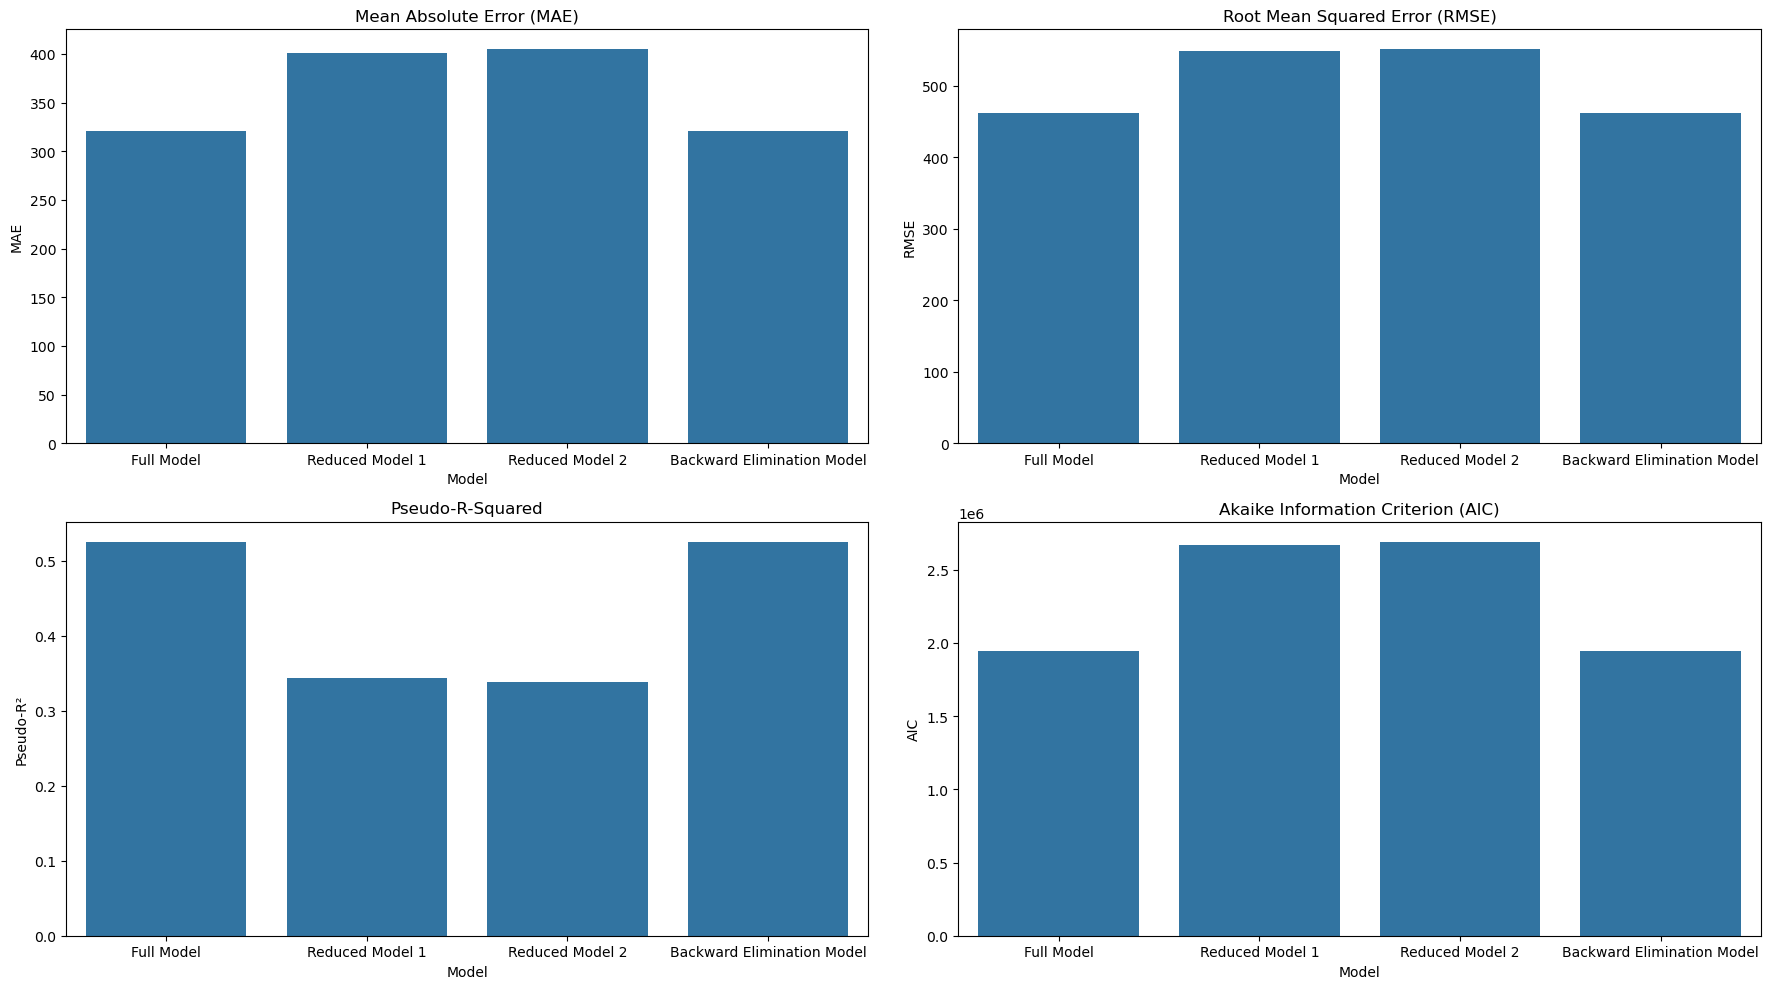

In [15]:

#Plot the evaluation metrics for comparison
fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Plot MAE
sns.barplot(x=metrics_df["Model"], y=metrics_df["MAE"], ax=axes[0, 0])
axes[0, 0].set_title("Mean Absolute Error (MAE)")
axes[0, 0].set_ylabel("MAE")

# Plot RMSE
sns.barplot(x=metrics_df["Model"], y=metrics_df["RMSE"], ax=axes[0, 1])
axes[0, 1].set_title("Root Mean Squared Error (RMSE)")
axes[0, 1].set_ylabel("RMSE")

# Plot Pseudo-R²
sns.barplot(x=metrics_df["Model"], y=metrics_df["Pseudo-R²"], ax=axes[1, 0])
axes[1, 0].set_title("Pseudo-R-Squared")
axes[1, 0].set_ylabel("Pseudo-R²")

# Plot AIC
sns.barplot(x=metrics_df["Model"], y=metrics_df["AIC"], ax=axes[1, 1])
axes[1, 1].set_title("Akaike Information Criterion (AIC)")
axes[1, 1].set_ylabel("AIC")

plt.tight_layout()
plt.show()


In [16]:
# Predict using the Full Model
y_pred_full = glm_model_full.predict(X_test_glm)

# Predict using Reduced Model 1
y_pred_reduced_1 = glm_model_reduced_1.predict(X_test_glm_reduced_1)

# Predict using Reduced Model 2
y_pred_reduced_2 = glm_model_reduced_2.predict(X_test_glm_reduced_2)

# Compare predictions with actual values (y_test)
comparison_full = pd.DataFrame({'Actual': y_test, 'Predicted Full': y_pred_full})
comparison_reduced_1 = pd.DataFrame({'Actual': y_test, 'Predicted Reduced 1': y_pred_reduced_1})
comparison_reduced_2 = pd.DataFrame({'Actual': y_test, 'Predicted Reduced 2': y_pred_reduced_2})

# Display comparisons
print("Full Model Predictions:")
print(comparison_full.head())
print("\nReduced Model 1 Predictions:")
print(comparison_reduced_1.head())
print("\nReduced Model 2 Predictions:")
print(comparison_reduced_2.head())


Full Model Predictions:
      Actual  Predicted Full
6056    1728      848.149160
5556     822     1282.166790
5990     658     1689.149526
7674    2716     1188.638642
3319    1083      388.331936

Reduced Model 1 Predictions:
      Actual  Predicted Reduced 1
6056    1728           651.521018
5556     822          1102.006681
5990     658          1084.590628
7674    2716          1023.076080
3319    1083           421.669335

Reduced Model 2 Predictions:
      Actual  Predicted Reduced 2
6056    1728           597.828682
5556     822          1070.083791
5990     658          1073.283425
7674    2716          1086.693736
3319    1083           446.287072


In [17]:
# Coefficients for the Full Model
coefficients_full = glm_model_full.params
print("Full Model Coefficients:")
print(coefficients_full)

# Coefficients for Reduced Model 1
coefficients_reduced_1 = glm_model_reduced_1.params
print("\nReduced Model 1 Coefficients:")
print(coefficients_reduced_1)

# Coefficients for Reduced Model 2
coefficients_reduced_2 = glm_model_reduced_2.params
print("\nReduced Model 2 Coefficients:")
print(coefficients_reduced_2)


Full Model Coefficients:
const                    5.919622
Hour                     0.045230
Temperature              0.035142
Humidity                -0.010525
Wind speed               0.006768
Visibility              -0.000018
Dew point temperature    0.008047
Solar Radiation         -0.067904
Rainfall                -0.507775
Snowfall                -0.238812
Day                      0.001996
Month                    0.021344
Weekday                 -0.013885
dtype: float64

Reduced Model 1 Coefficients:
const              4.861268
Hour               0.060978
Humidity           0.004997
Wind speed        -0.032136
Visibility         0.000202
Solar Radiation    0.241199
Rainfall          -0.569681
Snowfall          -0.658754
Day                0.005371
Month              0.035544
Weekday           -0.016903
dtype: float64

Reduced Model 2 Coefficients:
const              5.299002
Hour               0.059260
Wind speed        -0.042071
Visibility         0.000135
Solar Radiation    0.

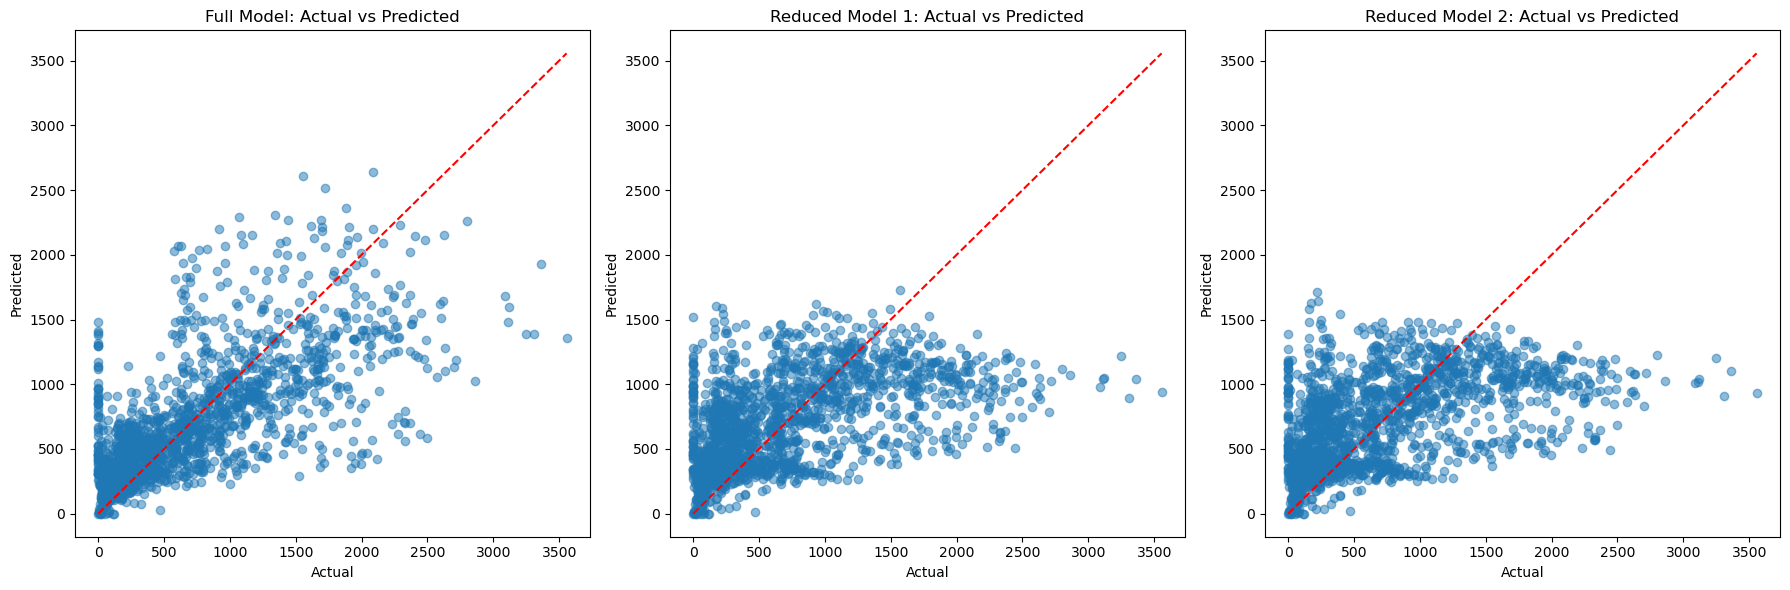

In [18]:

# Plot Actual vs Predicted for each model
plt.figure(figsize=(18, 6))

# Full Model
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_full, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Full Model: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Reduced Model 1
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_reduced_1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Reduced Model 1: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

# Reduced Model 2
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_reduced_2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title("Reduced Model 2: Actual vs Predicted")
plt.xlabel("Actual")
plt.ylabel("Predicted")

plt.tight_layout()
plt.show()


#### Model Coefficients Interpretation:
##### Full Model:

Hour, Temperature, Wind speed, and Dew point temperature have positive coefficients, indicating that as these variables increase, the target variable (Rented Bike Count) is expected to increase. Rainfall and Snowfall have negative coefficients, suggesting that more rainfall or snowfall leads to a decrease in bike rentals.Solar Radiation has a negative coefficient, implying that as solar radiation increases, bike rentals may decrease, which suggest the bikes are less popular on extremely sunny days.

##### Reduced Model 1:

This model, with features like Solar Radiation, Rainfall, and Snowfall, shows similar relationships. However, the coefficients for Visibility and Solar Radiation are much higher in this model than in the Full Model, which may suggest that removing features with high collinearity has allowed these predictors to have a greater impact. The effect of Humidity and Wind speed is different in this model, with Wind speed now having a negative impact and Humidity becoming positive.

##### Reduced Model 2:

Similar to Reduced Model 1, Solar Radiation and Rainfall have a noticeable influence on the target variable. The coefficients are quite similar between Reduced Model 1 and 2 for many features. Wind speed has a more pronounced negative effect in Reduced Model 2, suggesting that high wind speeds negatively affect bike rentals even more after reducing some features.

#### Conclusion:
It seems that the Full Model (with all features) performs the best based on MAE, RMSE, and AIC.
The Backward Elimination Model is equivalent to the Full Model, which means the removed features did not contribute significantly to improving model performance.
The Reduced Models 1 and 2 perform worse in comparison, suggesting that removing features may not always be beneficial, especially if those features contribute important information for predicting the target variable.